# Continuous Control

---

This notebook contains a solution for the Continuous Control project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). This solution was prepared on local machine under Ubuntu-20.04. Instructions for environment setup are located in README.md file.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
from unityagents import UnityEnvironment

import numpy as np
import matplotlib.pyplot as plt
import time
import torch

%matplotlib inline

Next, if not already done, fetch environment files and start it.

In [2]:
# fetch the Reacher Linux environment if not present
![[ ! -d "Reacher_Linux" ]] && wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip && unzip Reacher_Linux.zip

env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Or switch to reacher one


In [2]:
![[ ! -d "Reacher_Linux_one" ]] && wget -O Reacher_Linux_one.zip https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/one_agent/Reacher_Linux.zip && unzip Reacher_Linux_one.zip -d Reacher_Linux_one

env = UnityEnvironment(file_name='Reacher_Linux_one/Reacher_Linux/Reacher.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# 3. A2C

DQN learing algorithm and model is contained in the Agent class located in dqn_agent.py. The cell below initializes learning agent and prints model structure:

## Model

In [22]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        super().__init__()
        self.seed = torch.manual_seed(seed)

        self.state_encoding = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.BatchNorm1d(fc1_units),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
        )

        self.mean = nn.Sequential(
            nn.Linear(fc2_units, action_size),
            nn.Tanh()
        )
        self.variance = nn.Sequential(
            nn.Linear(fc2_units, action_size),
            nn.Softplus()
        )

    def forward(self,x):
        """ Action is sampled from normal distribution mean and variance """
        x = self.state_encoding(x)
        return self.mean(x), self.variance(x)


class Critic(nn.Module):
    def __init__(self, state_size, seed, fc1_units=128, fc2_units=64):
        super().__init__()
        self.seed = torch.manual_seed(seed)

        self.state_encoding = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.BatchNorm1d(fc1_units),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
        )

        self.output_layer = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a critic (value) network that maps (state) -> V-values."""
        x = self.state_encoding(state)
        return self.output_layer(x)

## Agent

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

# from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Normal

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

GAMMA = 0.9             # discount factor
LR_ACTOR = 5e-3         # learning rate of the actor 
LR_CRITIC = 5e-3        # learning rate of the critic
ENTROPY = 1e-3          # strength of the entropy regularization term
CLIPPING = 5            # gradient clipping coefficient
# UPDATE_EVERY = 5        # action interval at which model is updated

class Agent:
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, device):#, update_every=UPDATE_EVERY):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.device = device
        # self.update_every = update_every

        # Replay memory
        self.memory = RolloutBuffer()

        # Actor Network
        self.policy = Actor(state_size, action_size, random_seed).to(device)
        self.policy_optimizer = optim.RMSprop(self.policy.parameters(), lr=LR_ACTOR)

        # Critic Network
        self.state_value = Critic(state_size, random_seed).to(device)
        self.state_value_optimizer = optim.RMSprop(self.state_value.parameters(), lr=LR_CRITIC)

    def step(self, state, actions, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / rewards
        self.memory.add(state, actions, reward, next_state, done)

    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        mean = torch.zeros(state.shape[0], action_size)
        variance = torch.zeros(state.shape[0], action_size)
        self.policy.eval()
        with torch.no_grad():
            for worker in range(state.shape[0]):
                worker_state = state[worker].unsqueeze(0)
                mean[worker], variance[worker] = self.policy(worker_state)
        self.policy.train()

        sigma = torch.sqrt(variance)
        policy = Normal(mean, sigma)

        return policy.sample()

    def discounted_returns(self, rewards, dones, V_last):
        G = torch.zeros_like(rewards)
        G[-1] = V_last * (1 - dones[-1])

        for i in reversed(range(len(rewards) - 1)):
            G[i] = rewards[i] + GAMMA * G[i - 1]

        return G

    def learn(self):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        e = self.memory.sample()

        e_states = torch.FloatTensor(e.state).to(device)
        e_rewards = torch.FloatTensor(e.reward).to(device)
        e_actions = torch.stack(e.action).to(device)
        e_last_states = torch.FloatTensor(e.next_state[-1]).to(device)
        e_dones = torch.FloatTensor(e.done).to(device)

        for worker in range(num_agents):
            states = e_states[:, worker]
            rewards = e_rewards[:, worker]
            actions = e_actions[:, worker]
            last_states = e_last_states[worker]
            dones = e_dones[:, worker]


            # ---------------------------- update critic ---------------------------- #
            # Compute V targets for current states (y_i)
            # Compute critic loss
            V_expected = self.state_value(states)

            self.state_value.eval()
            with torch.no_grad():
                V_next_expected = self.state_value(last_states.unsqueeze(0))
            self.state_value.train()

            R = self.discounted_returns(rewards, dones, V_next_expected).to(device)
        
            critic_loss = 0.5 * F.mse_loss(V_expected, R)
            # Minimize the loss
            self.state_value_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.state_value.parameters(), CLIPPING)
            self.state_value_optimizer.step()

            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss

            mean, variance = self.policy(states)
            sigma = torch.sqrt(variance)
            policy_distro = Normal(mean, sigma)
            logprobs = policy_distro.log_prob(actions)
            entropy = policy_distro.entropy()

            # A(s,a) = Q(s,a) - V(s)
            actor_loss = (-(R - V_expected.detach()) * logprobs + ENTROPY * entropy)
                
            w_actor_loss = actor_loss.mean()
            # Minimize the loss
            self.policy_optimizer.zero_grad()
            w_actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), CLIPPING)
            self.policy_optimizer.step()

class RolloutBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, seed):
        self.memory = list()
        field_names=[
            "state", "action", "reward", "next_state", "done"
        ]
        self.experience = namedtuple("Experience", field_names=field_names)
        self.fields_len = len(field_names)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(
            state,
            action,
            np.expand_dims(reward, 1),
            next_state,
            np.expand_dims(done, 1)
        )

        self.memory.append(e)

    def sample(self):
        """Consume all rollout of experiences from memory."""
        experiences = self.experience(*zip(*self.memory))
        
        self.memory.clear()
        return experiences

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

agent = Agent(state_size=state_size, action_size=action_size, random_seed=0, device=device)
print(agent.policy)
print(agent.state_value)

Actor(
  (state_encoding): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (mean): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Tanh()
  )
  (variance): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)
Critic(
  (state_encoding): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [72]:
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations

In [77]:
actions = agent.act(states)       # select an action

env_info = env.step(actions.detach().cpu().numpy())[brain_name]       # send the action to the environment
next_states = env_info.vector_observations     # get the next state
rewards = env_info.rewards                     # get the reward
dones = env_info.local_done                    # see if episode has finished
agent.step(states, actions, rewards, next_states, dones)
states = next_states

In [18]:
s = agent.memory.sample()
s

Experience(state=(array([[ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -4.37113883e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  7.90150833e+00,
        -1.00000000e+00,  1.25147629e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -1.29508138e-01],
       [ 0.00000000e+00, -4.00000000e+00,  0.00000000e+00,
         1.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -4.37113883e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         0.00000000e+00,  1.00000000e

## 4. Train the agent

Now run DQN learning algorithm and display average score over episodes benchmark. In order to solve the environment, the agents must get an average score of +30 (over 100 consecutive episodes, and over all agents).

Episode 100	Average Score: 0.01
Learning took: 1008.1557946205139, per episode: 10.08155794620514


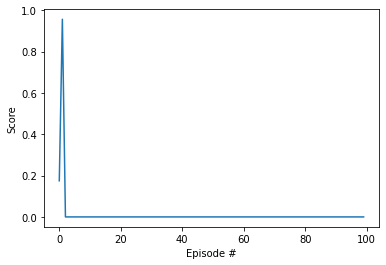

In [6]:
def a2c(n_episodes=100, max_t=1000, solved_score=30):
    """Advantage Actor Critic (synchronous).
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)                    # select an action
            actions_clamped = torch.clamp(actions, -1, 1).cpu().numpy()
            env_info = env.step(actions_clamped)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break

        agent.learn()
        episode_score = np.mean(score)
        scores_window.append(episode_score)       # save most recent score
        scores.append(episode_score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.model_local.state_dict(), 'trained_weights.pth')
            break
    return scores

start = time.time()
scores = a2c()
learning_took = time.time() - start

print("Learning took: {}, per episode: {}".format(learning_took, learning_took/len(scores)))

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5. Evaluate the agent

Perform a test run for a single episode and display the total score of untrained agent. Score over 13 is considered success.

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


# DDPG

## Model

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=100, fc2_units=100):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=100, fc2_units=100):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


## Agent

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.soft_update(self.actor_local, self.actor_target, 1.0)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.soft_update(self.critic_local, self.critic_target, 1.0)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, np.expand_dims(reward, 1), next_state, np.expand_dims(done, 1))
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size // 20)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)

## Train

In [7]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations
action = agent.act(state)
env_info = env.step(action)[brain_name]

Episode 100	Average Score: 21.73
Episode 126	Average Score: 30.23
Environment solved in 26 episodes!	Average Score: 30.23


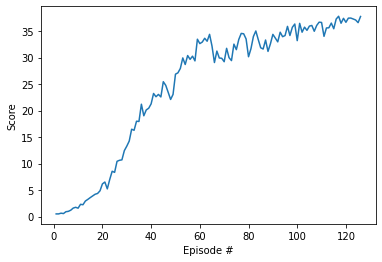

In [9]:
def ddpg(n_episodes=1000, max_t=1000, solved_score=30):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)       # select an action
            
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished
            # for i in range(num_agents):
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break
        episode_score = np.mean(score)
        scores_window.append(episode_score)       # save most recent score
        scores.append(episode_score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Test

In [21]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
score = np.zeros(num_agents)
for j in range(1000):
    action = agent.act(state, add_noise=False)     # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations      # get the next state
    reward = env_info.rewards                      # get the reward
    done = env_info.local_done                     # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if np.any(done):                               # exit loop if episode finished
        break

print("Score: {}, steps: {}".format(np.mean(score), j))

Score: 39.369999120011926, steps: 999


# Close

When finished, you can close the environment.

In [ ]:
env.close()